# ARIMA Decompose

In [1]:
import datetime as dt
import pandas as pd
from pandas import read_csv
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

In [2]:
import fxcmpy
TOKEN = 'ccf0e2248bf73ca5f37919cc53913fa67935cea4'
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error', server='real')
print(con.get_instruments())

['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CHF', 'EUR/CHF', 'AUD/USD', 'USD/CAD', 'NZD/USD', 'EUR/GBP', 'EUR/JPY', 'GBP/JPY', 'CHF/JPY', 'GBP/CHF', 'EUR/AUD', 'EUR/CAD', 'AUD/CAD', 'AUD/JPY', 'CAD/JPY', 'NZD/JPY', 'GBP/CAD', 'GBP/NZD', 'GBP/AUD', 'AUD/NZD', 'USD/SEK', 'EUR/SEK', 'EUR/NOK', 'USD/NOK', 'USD/MXN', 'AUD/CHF', 'EUR/NZD', 'USD/ZAR', 'USD/HKD', 'ZAR/JPY', 'USD/TRY', 'EUR/TRY', 'NZD/CHF', 'CAD/CHF', 'NZD/CAD', 'TRY/JPY', 'USD/ILS', 'USD/CNH', 'AUS200', 'ESP35', 'FRA40', 'GER30', 'HKG33', 'JPN225', 'NAS100', 'SPX500', 'UK100', 'US30', 'Copper', 'CHN50', 'EUSTX50', 'VOLX', 'USDOLLAR', 'US2000', 'USOil', 'UKOil', 'SOYF', 'NGAS', 'USOilSpot', 'UKOilSpot', 'WHEATF', 'CORNF', 'Bund', 'XAU/USD', 'XAG/USD', 'EMBasket', 'JPYBasket', 'BTC/USD', 'BCH/USD', 'ETH/USD', 'LTC/USD', 'XRP/USD', 'CryptoMajor', 'EOS/USD', 'XLM/USD', 'ESPORTS', 'BIOTECH', 'CANNABIS', 'FAANG', 'CHN.TECH', 'CHN.ECOMM', 'USEquities', 'BA.us', 'BAC.us', 'DIS.us', 'F.us', 'JPM.us', 'PFE.us', 'T.us', 'XOM.us', 'AAPL.us', '

In [3]:
start = dt.datetime(2010, 1, 1)
stop = dt.datetime(2020, 11, 25)
data = con.get_candles('EUR/USD', period='D1',start=start, stop=stop,columns=['asks', 'tickqty'],with_index=False)

In [4]:
# Rename the columns

data.rename(columns = {'askopen':'open',
                       'askclose':'close',
                       'askhigh':'high',
                       'asklow':'low',
                       'tickqty':'volume'}, inplace = True) 

In [5]:
data

,date,open,close,high,low,volume
0,2010-01-04 22:00:00,1.43332,1.44144,1.44563,1.42587,55015
1,2010-01-05 22:00:00,1.44144,1.43676,1.44845,1.43472,60382
2,2010-01-06 22:00:00,1.43676,1.44091,1.44357,1.42835,58258
3,2010-01-07 22:00:00,1.44091,1.43104,1.44476,1.43000,56049
4,2010-01-08 22:00:00,1.43104,1.44156,1.44399,1.42646,58253
...,...,...,...,...,...,...
3230,2020-11-20 22:00:00,1.18776,1.18583,1.18915,1.18505,193200
3231,2020-11-22 22:00:00,1.18581,1.18571,1.18608,1.18532,131
3232,2020-11-23 22:00:00,1.18589,1.18421,1.19068,1.18006,213636
3233,2020-11-24 22:00:00,1.18417,1.18981,1.18981,1.18389,199070


In [6]:
data = pd.DataFrame(data[['date','close']])
data

,date,close
0,2010-01-04 22:00:00,1.44144
1,2010-01-05 22:00:00,1.43676
2,2010-01-06 22:00:00,1.44091
3,2010-01-07 22:00:00,1.43104
4,2010-01-08 22:00:00,1.44156
...,...,...
3230,2020-11-20 22:00:00,1.18583
3231,2020-11-22 22:00:00,1.18571
3232,2020-11-23 22:00:00,1.18421
3233,2020-11-24 22:00:00,1.18981


In [7]:
data.dtypes

date     datetime64[ns]
close           float64
dtype: object

In [8]:
data.set_index('date',inplace=True)

<AxesSubplot:xlabel='date'>

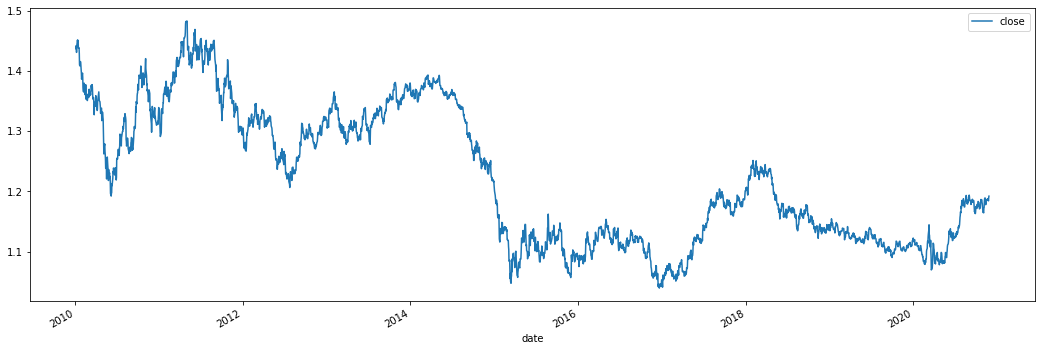

In [9]:
data.plot(figsize=(18,6))


The overall all time trend is down ub 2011, 2012, 2015 and slowly go up next years

In [10]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

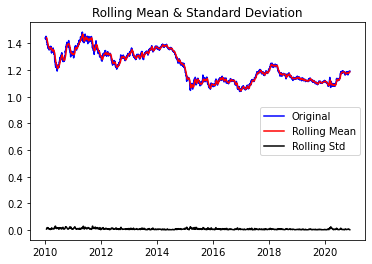

In [11]:
test_stationarity(data)

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:


*   constant mean
*   constant variance
*   an autocovariance that does not depend on time.


In [12]:
def difference(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["close"][i] - dataset["close"][i - interval]
        diff.append(value)
    return (diff)

Now that we have AR term lets calculate the differencing term

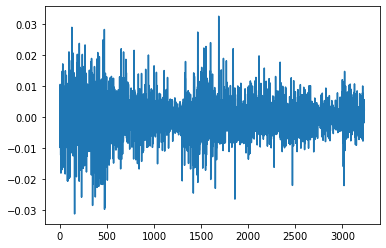

In [13]:
diff = difference(data)
plt.plot(diff)
plt.show()

We can see that the difference is kinda significant clearly, but we also have to apply transformation which penelize higher values more than smaller values.

There can be taking a log, square root, cube rott, etc. Lets take a log transform here for simplicity:

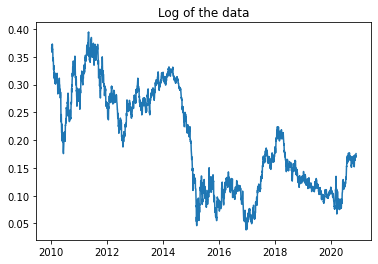

In [14]:
ts_log = np.log(data)
plt.title('Log of the data')
plt.plot(ts_log)
plt.show()

# Moving Avarage

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 200 values. Pandas has specific functions defined for determining rolling statistics.

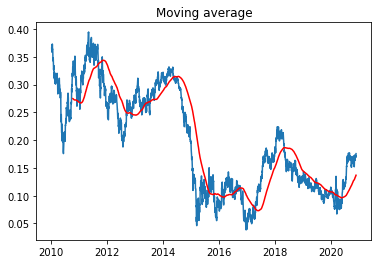

In [15]:
moving_avg = ts_log.rolling(200).mean()
plt.plot(ts_log)
plt.title('Moving average')
plt.plot(moving_avg, color='red')
plt.show()

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 200 values, rolling mean is not defined for first 199 values. This can be observed as:



In [16]:
ts_log_moving_avg_diff = ts_log - moving_avg

since we are taking average of last 12 values, rolling mean is not defined for first 11 values. So we remove the NAN values

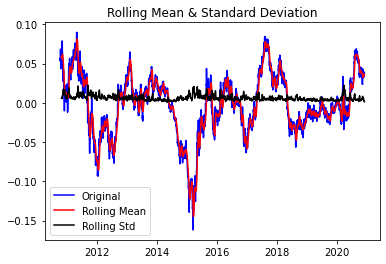

In [17]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Weighted Moving Average: Here more recent values are given a higher weight

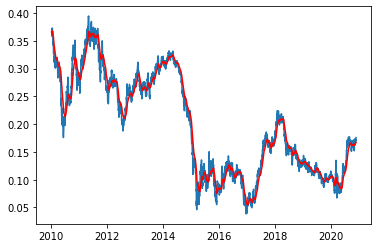

In [18]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
#parameter halflife is used to define the amount of exponential decay
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

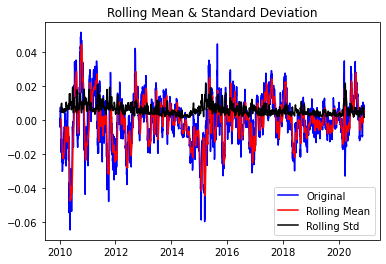

In [19]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

# Eliminating Trend and Seasonality
The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

Differencing – taking the differece with a particular time lag
Decomposition – modeling both trend and seasonality and removing them from the model.

# Differencing

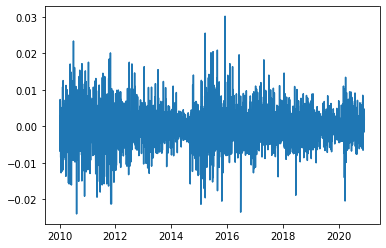

In [20]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

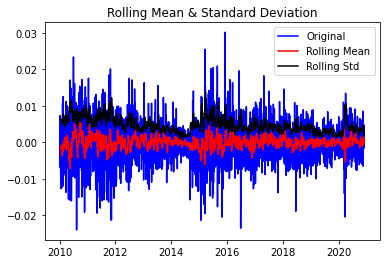

In [21]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# Decomposition

c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


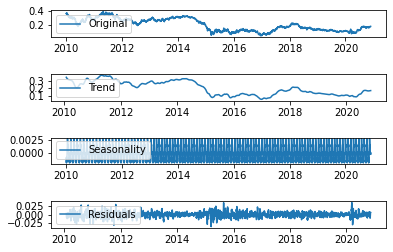

<Figure size 432x288 with 0 Axes>

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(711)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(713)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(715)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(717)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout(pad=3.0)

Here we can see that the trend, seasonality are separated out from data and we can model the residuals

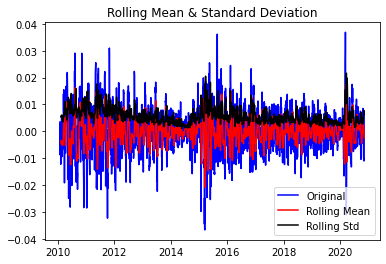

In [23]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:
*   Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
*   Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
*   Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.
An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


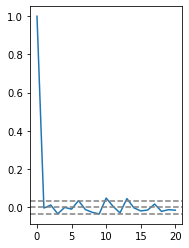

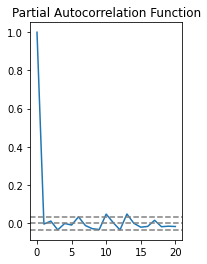

<Figure size 432x288 with 0 Axes>

In [24]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.show()
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()

The values has been taken when the line first cuts the 0. The ACF graph is drawn to determine the q value and the PACF graph is drawn to determine the p value. From the above graphs it can be see that the value of p is 1 and the value of q is 1 respectively. Now these values have to be substituted in the ARIMA model to get the predictions.


# AR Model

c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


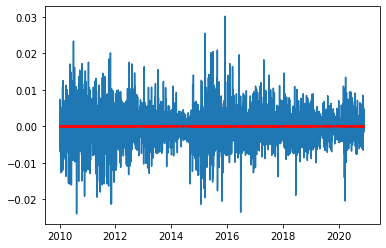

In [25]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 0), freq=ts_log.index.inferred_freq)  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.show()

# MA Model

c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


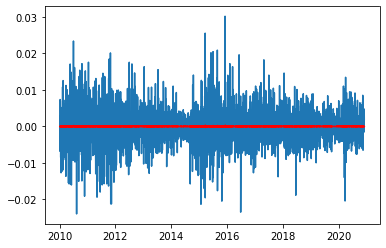

In [26]:
model = ARIMA(ts_log, order=(0, 1, 2), freq=ts_log.index.inferred_freq)  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.show()

# ARIMA Model

c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


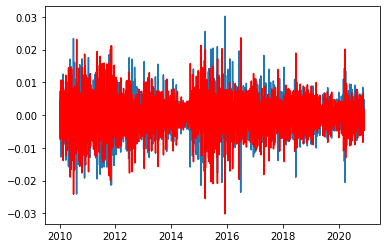

In [27]:
model = ARIMA(ts_log, order=(2, 2, 1), freq=ts_log.index.inferred_freq)  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()